In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [182]:
data = pd.read_csv('airline-passenger-traffic.csv', header=None)
data.columns = ['Month', 'Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## Time Series Analysis

### Plot time series data

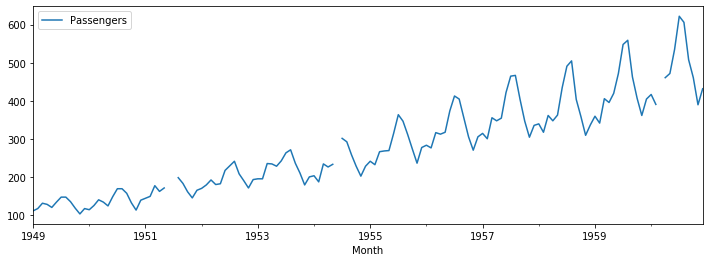

In [3]:
data.plot(figsize=(12,4))

## Handling missing values

### Mean inputation

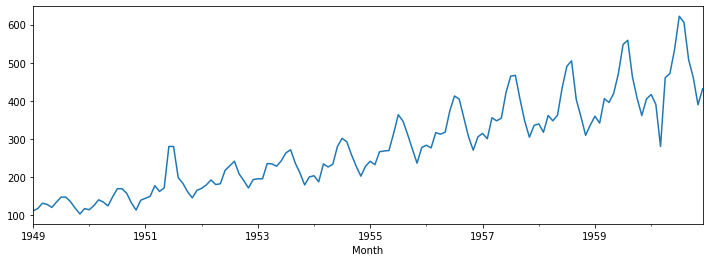

In [4]:
data = data.assign(Passengers_Mean_imputation = data['Passengers'].fillna(data['Passengers'].mean()))
data['Passengers_Mean_imputation'].plot(figsize=(12,4))

##### Problem:-
1952 takes higher values than expected.

1960 takes lower value than expected.

### Linear interpolation
You draw a straight line joining the next and previous points of the missing values in the data.

In [5]:
data = data.assign(Passengers_Linear_Interpolation = data['Passengers'].interpolate(method='linear'))
data.head()

,Passengers,Passengers_Mean_imputation,Passengers_Linear_Interpolation
Month,,,
1949-01-01,112.0,112.0,112.0
1949-02-01,118.0,118.0,118.0
1949-03-01,132.0,132.0,132.0
1949-04-01,129.0,129.0,129.0
1949-05-01,121.0,121.0,121.0


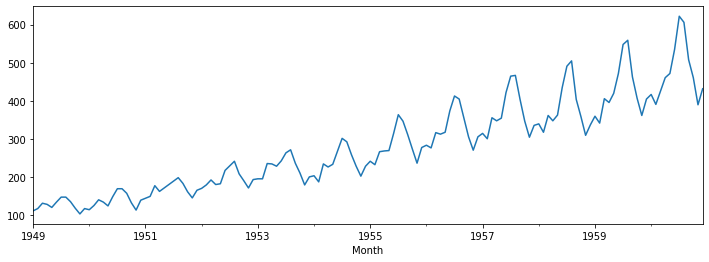

In [6]:
data['Passengers_Linear_Interpolation'].plot(figsize=(12,4))

We will go with the linear interpolation for imputing missing values.

## Outlier detection

### Box plot and interquartile range

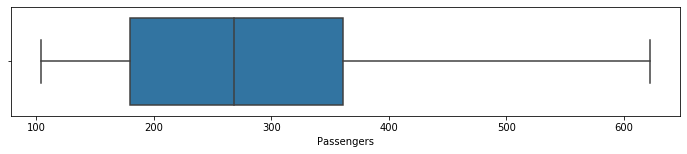

In [7]:
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(data['Passengers'], whis=1.5)

#### whis=1.5

1st quartile = 180

3rd quartile = 360

Quartile range = (3rd quartile - 1st quartile) = 360-180 = 180

***Whisker on the upper side***

3rd quartile + (Quartile range * whis) = 360 + (180 * 1.5) = 360 + 270 = 630

There is no outliers above the whisker 630.

***Whisker on th lower side***

1st quartile - (Quartile range * whis) = 180 - (180 * 1.5) = -90

There is no outliers on the negative side of the lower whisker.

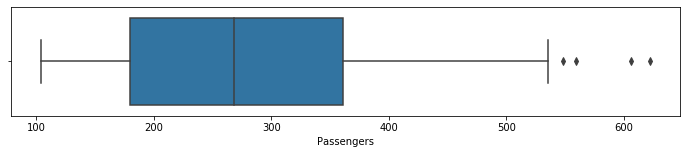

In [8]:
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(data['Passengers'], whis=1)

#### whis=1

1st quartile = 180

3rd quartile = 360

Quartile range = (3rd quartile - 1st quartile) = 360-180 = 180

***Whisker on the upper side***

3rd quartile + (Quartile range * whis) = 360 + (180 * 1) = 360 + 180 = 540

There are 4 outliers above the whisker 540.


#### Conclusion for selecting whis = 1.5

So from the above analysis of whis 1 and 1.5, we should select the whis=1.5 quartile range. Because we don't want to miss any of the data in this time series analysis.

### Histogram plot

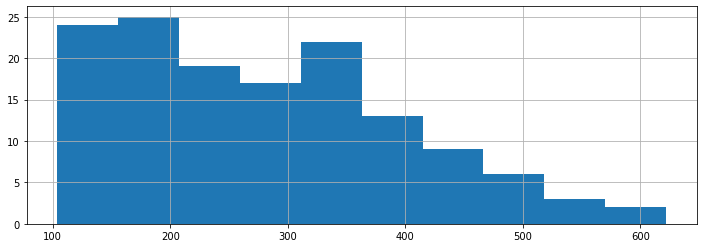

In [9]:
data['Passengers'].hist(figsize=(12,4))

1. We can see that the frequency of the number of passengern are nice and continious. 
2. As the number of passengers increases, the frequency of that number of passengers decreases. 

##### Conclusion
There is no outliers detected.

#### Doing the following
1. Dropping Passengers_Mean_imputation and Passengers columns.
2. Renaming Passengers_Linear_Interpolation column to Passengers column.

We will only work with the Linear interpolation imputation.

In [10]:
data.head()

,Passengers,Passengers_Mean_imputation,Passengers_Linear_Interpolation
Month,,,
1949-01-01,112.0,112.0,112.0
1949-02-01,118.0,118.0,118.0
1949-03-01,132.0,132.0,132.0
1949-04-01,129.0,129.0,129.0
1949-05-01,121.0,121.0,121.0


In [11]:
data = data.drop(['Passengers', 'Passengers_Mean_imputation'], axis=1)

In [12]:
data.rename(columns={'Passengers_Linear_Interpolation' : 'Passengers'}, inplace=True)

In [13]:
data.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## Time series decomposition

### Additive seasonal decomposition

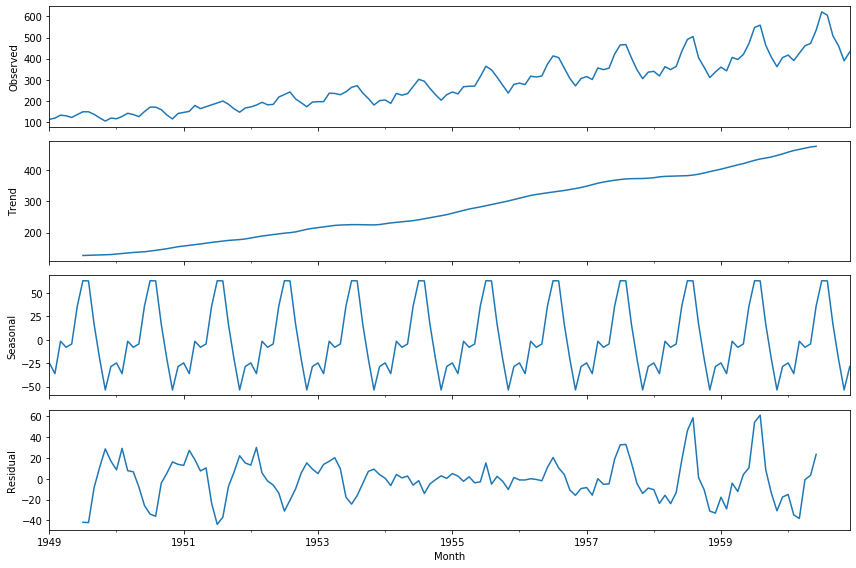

In [14]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='additive')
fig = decomposition.plot()
plt.show()

#### Analysis:-
1. ***Observed*** - Actual data
2. ***Trend*** - Increasing or decreasing trend.
3. ***Seasonal*** - 
    - Varies from +50 to -50 with the mean 0. 
    - Each cycle represents each year trend.
    - The value in the Y-axis has to be `added` to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is +50 and the trend value is 100. Hence, teh actual value(passengers number) will (seasonal+Trend) value = 50+100 = 150.
4. ***Residual*** - It is the noise pattern of the time series data for each year, which was not captured by the two components - Trend and Seasonality. Residual is the left over after decomposition of the two major components (Trend and Seasonality)


### Multiplicative seasonal decomposition

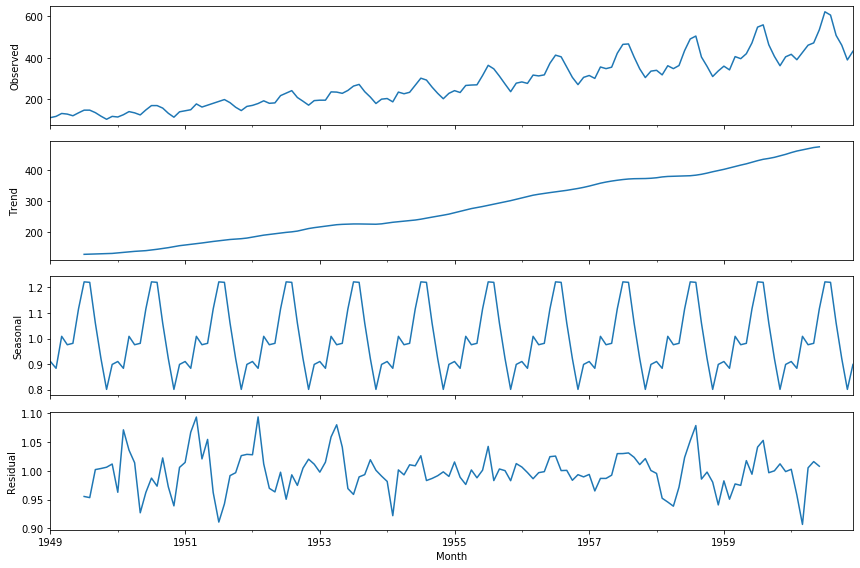

In [15]:
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='multiplicative')
fig = decomposition.plot()
plt.show()

#### Analysis:-

***Seasonal*** - 
1. Varies from 0.8 to 1.2 
2. The value in the Y-axis has to be `multiplied` to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is `1.2` and the trend value is `100`. Hence, the actual value(passengers number) will (seasonal X Trend) value = 1.2 X 100 = 120.


## Build and Evaluate time series forecast

#### Splitting the data into train and test set

We are going to forecat for the last two years. 1959 and 1960.

Last 24 records contain 1959 and 1960 data.

In [16]:
train_len = 120
train = data[0:train_len]
# 1959 and 1960 data
test = data[train_len:]

In [17]:
train.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [18]:
test.head()

,Passengers
Month,
1959-01-01,360.0
1959-02-01,342.0
1959-03-01,406.0
1959-04-01,396.0
1959-05-01,420.0


### Naive method

Forecast = Last month’s data

Or the last data of the train set, which will be assigned to all the records of the test data.

In [19]:
# Creating a new dataframe by copying the test data
# Because we will forecast the last two years data and comapre the forecast in this new coppied dataframe.
y_hat_naive = test.copy()
y_hat_naive.head()

,Passengers
Month,
1959-01-01,360.0
1959-02-01,342.0
1959-03-01,406.0
1959-04-01,396.0
1959-05-01,420.0


In [20]:
# Assigning the last value of the train set (December 1958 value) to all the test data records
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

In [21]:
y_hat_naive.head()

,Passengers,naive_forecast
Month,,
1959-01-01,360.0,337.0
1959-02-01,342.0,337.0
1959-03-01,406.0,337.0
1959-04-01,396.0,337.0
1959-05-01,420.0,337.0


#### Plot train, test and forecast data

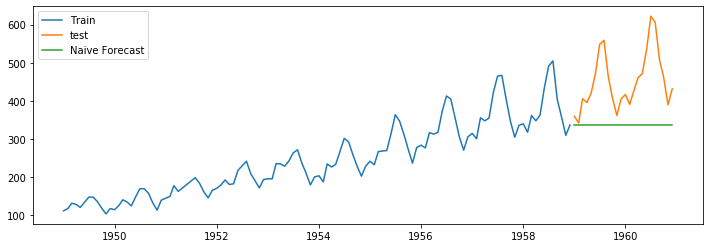

In [22]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive Forecast')
plt.legend(loc='best')
plt.show()

##### Analysis
1. All the values are same as we assigned all the forecasting records to the last value of the train set(Dec 1958).
2. The forecasting is undervalued when compared to the actual test data value.

### Simple average method

Forecast = Average of all past months’ data

Average of all the train data  values assigned to the test data.

In [23]:
y_hat_avg = test.copy()

In [24]:
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

In [25]:
y_hat_avg.head()

,Passengers,avg_forecast
Month,,
1959-01-01,360.0,245.891667
1959-02-01,342.0,245.891667
1959-03-01,406.0,245.891667
1959-04-01,396.0,245.891667
1959-05-01,420.0,245.891667


##### Plotting train, test and forecast

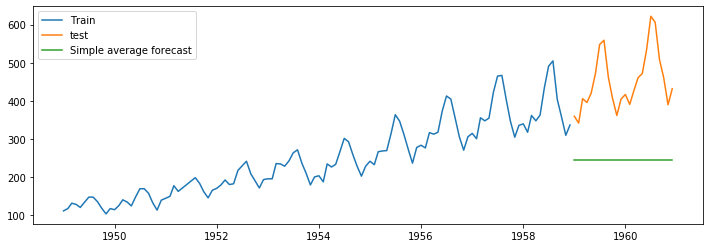

In [26]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.show()

##### Analysis
1. We have unnder estimated the actual test value while doing the forecasting. Because we took the mean of all the lower values, while the trend of the time series is in increasing pattern.


## Calculate RMSE and MAPE Error

In [27]:
from sklearn.metrics import mean_squared_error

### Error for Naive method

#### RMSE

In [28]:
# mean_squared_error is a sqaured term of the error
# In order to make the error comparable with the target variable, we have to take the square root of the error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
rmse

137.51

#### MAPE (Mean absolute percentage error)

In [29]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_naive['naive_forecast'])/test['Passengers'])*100),2)
mape

23.63

In [30]:
results = pd.DataFrame({'Method':['Naive method'], 'RMSE':[rmse], 'MAPE':[mape]})
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63


MAPE is the percentage of error.

So, we can see that we are 77% accurate to forecast.

### Error for Simple average method

#### RMSE

In [31]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
rmse

219.69

#### MAPE

In [32]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_avg['avg_forecast'])/test['Passengers'])*100),2)
mape

44.28

In [33]:
results = results.append({'Method':'Simple average method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28


We can see that both RMSE and MAPE errors have increased with teh Simple average method.

Accuracy = 1 - MAPE

## Simple moving average method

Considering the last observation in the time series has more impact on the future rather than the first observation, in the simple moving average method, we take the average of only the last observations to forecast the future. 

In [34]:
# We are copying entire data because we want to see the forecast for the entire dataset (train and test)
y_hat_sma = data.copy()

In [35]:
# Moving average window. We will take the avg of last 12 months for forecasting the future. 
ma_window = 12

In [36]:
# Rolling function calculated the last number of records
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()

We are predicting the test set on basis of the train set. By simple avg method, we are taking the avg of the last 12 months and forecasting that avg value for the future months.

Here, we are forecasting 1959 and 1960. For 1959 Jan we will get the average of the last 12 months from the train set. But when we will forecast for Feb 1959, then for taking the last 12 months the Jan 1959, which belongs to the test set will be calculated for the avg calculation. 

Hecne, in the below code we are fixing all the test set values with the last 12 months values from the train set.

In [37]:
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

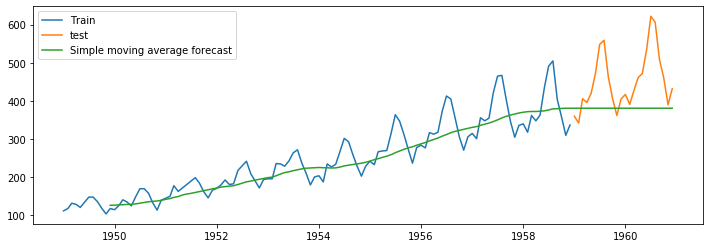

In [38]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.show()

##### Analysis
1. We can see that teh result is better than the simple avg or naive method. 
2. The seasonal effect can not be captured. 
3. There is a trend in the forecasting line which grows linearly.

In [39]:
# We are taking only the test data points of y_hat_sma. After the train_len data points
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
rmse

103.33

In [40]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100),2)
mape

15.54

In [41]:
results = results.append({'Method':'Simple moving average method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54


##### Analyssis
1. We see far better results than the other two methods.
2. Hence the `recent past average` data is better to forecast the future. 

Now lets try with :-

***ma_window = 6***

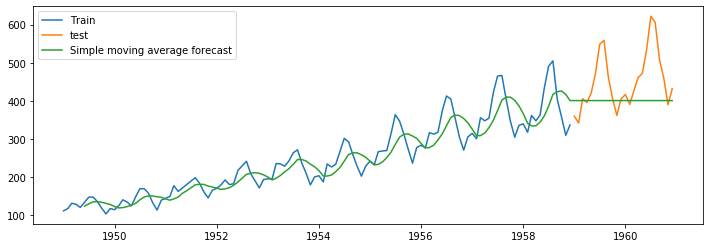

In [42]:
ma_window = 6
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.show()

We can see that with lower number of recent past data(6 months) average, the forecast line gets little seasonal passtern, just like the actual pattern.

This is because, now we are taking only last 6 months data to forecast, which corresponds to the similarity of the next few months.

***ma_window = 3***

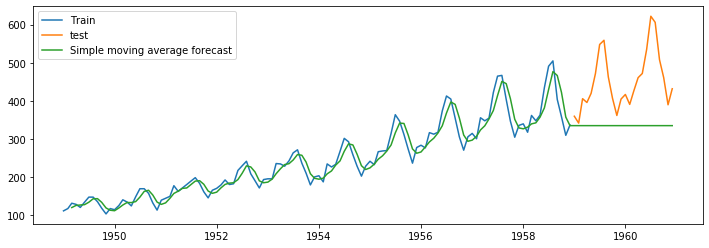

In [43]:
ma_window = 3
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.show()

With more lesser number of past data (3 months), the forecasted line is almost hugging to the actual line.

#### Conclusion
As we need to forecast for the longer time period for 2 or 5 years, it is better to take a moderate or reasonable amount of past data average such as ***12 months***.

# Exponential Smoothing Family

- Simple exponential smoothing (Captures - Only Level)
- Holt's exponential smoothing (Level+Trend)
- Holt's Winter exponential smoothing (Level+Trend+Seasonality)

## Simple Exponential Smoothing

In [44]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [45]:
# Instantiate the model
model = SimpleExpSmoothing(train['Passengers'])
# Fit the model with alpha = 0.2 
# optimized = False means, we are explicitly definign the smoothing_level.
# optimized = True means - Automitacially it will define a smoothing_level based on RMSE
model_fit = model.fit(smoothing_level = 0.2, optimized=False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_slope': None,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 112.0,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [46]:
y_hat_ses = test.copy()
# Forecast for 24 months
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

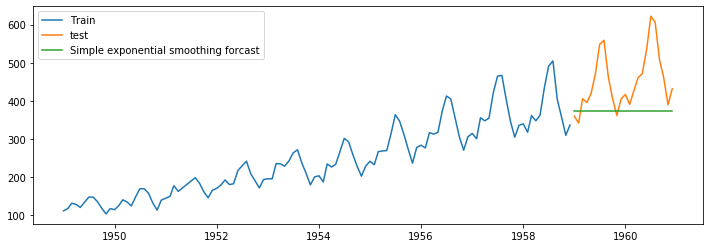

In [47]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

#### Analysis
1. No seasonality captures.
2. Most recent observation gets higher weightages than the older ones for forecasting.

In [48]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
rmse

107.65

In [49]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_ses['ses_forecast'])/test['Passengers'])*100),2)
mape

16.49

In [50]:
results = results.append({'Method':'Simple expenential smoothing method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54
3,Simple expenential smoothing method,107.65,16.49


#### Analysis
1. We can see that with alpha = 0.2 the RMSE and MAPE has little increased that Simple moving avg method.

***For smoothing_level(alpha) with 0***

The forecasted line will be very low. Because the old observations will get higher weightage and the recent observations will get no weightage.

***For smoothing_level(alpha) with 1***

The forecasted line be similar as `Naive method`. Because the latest observations will get all the weightage and the older observations will get no weightage.

***Optimal alpha=0.2***

We gat an optimum forecasted line.

### Holt's Exponential Smoothing method

Captures both Level and Trend .

In [51]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [52]:
# We have to pass an array of the dataframe into the ExponentialSmoothing instance
# We are using additive trend because, from the time serices we can see that the data is linear
# In case of geometric trend we can use multiplicative trend
# seasonal=None Because we are not capturing seasonality in this model
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12, trend='additive', seasonal=None)

In [53]:
# smoothing_level. It is the level parameter (alpha)
# smoothing_slope - It is the trend parameter (beta) 
model_fit = model.fit(smoothing_level = 0.2, smoothing_slope = 0.01, optimized=False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_slope': 0.01,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 112.0,
 'initial_slope': 6.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [54]:
y_hat_holt = test.copy()
# We are forecasting for next 24 months
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

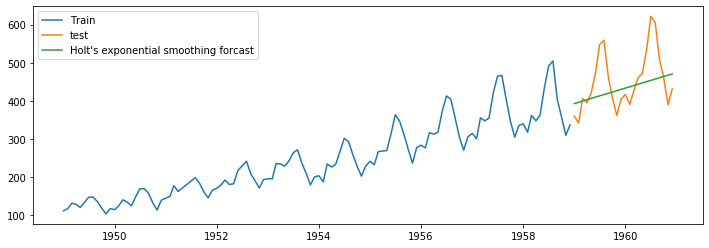

In [55]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

#### Analysis
1. We can see that we are able to capture the trend of the data.
2. We were not able to capture the seasonality.

In [56]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
rmse

71.94

In [57]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_holt['holt_forecast'])/test['Passengers'])*100),2)
mape

11.11

In [58]:
results = results.append({'Method':'Holt\'s expenential smoothing method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54
3,Simple expenential smoothing method,107.65,16.49
4,Holt's expenential smoothing method,71.94,11.11


#### Analysis
1. We can see both the errors have reduced.

***smoothing_slope = 0.01***

We are giving moderate weightage to the most recent values. Also, capturing the older values trend.

***smoothing_slope = 0.1***

We are giving more weightage to the most recent values. And lesser weightage to the older values trend.

Hence, the forecasted line becomes flat. Because if we notice that in 1958 Nov to Dec the trend is very low. And we are giving more weightage to this low trend than capturing the entire trend throughout the year.

## Holt-Winters's Exponential Smoothing

Captures Level, Trend and Seasonality.

### Additive method

In [59]:
y_hat_hwa = test.copy()

In [60]:
# We have to pass an array of the dataframe into the ExponentialSmoothing instance
# seasonal_periods = 12. Because the seasonality is on monthly basis. If the seasonality would have quarterly basis then seasonal_periods = 4 (4 quarters in an year)
# seasonal=additive for additive method
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12, trend='additive', seasonal='additive')

In [61]:
# optimized=True . Here we are letting the system choose the optimal alpha, beta and gamma parameter.
model_fit = model.fit(optimized=True)

In [62]:
model_fit.params

{'smoothing_level': 0.2631578931410045,
 'smoothing_slope': 0.05162966063531352,
 'smoothing_seasonal': 0.7368421036673203,
 'damping_slope': nan,
 'initial_level': 211.55099898334475,
 'initial_slope': 1.739191327984698,
 'initial_seasons': array([-100.18118445,  -94.20464777,  -80.29175569,  -83.41758364,
         -91.45908075,  -77.45094339,  -64.48324354,  -64.57340558,
         -76.66644166,  -93.73584129, -108.67610955,  -94.50947703]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [63]:
# Forecast for last 24 months
y_hat_hwa['hwa_forecast'] = model_fit.forecast(24)

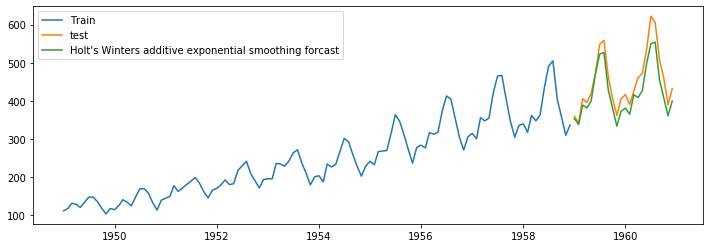

In [64]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_hwa['hwa_forecast'], label='Holt\'s Winters additive exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

#### Analysis
1. It captures the trend, which we can see that the forecasted values are little higher level than the train level.
2. It also captures teh seasonality.
3. The peak of the forecasted value is little lesser than the actual.

In [65]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hwa_forecast'])).round(2)
rmse

35.1

In [66]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_hwa['hwa_forecast'])/test['Passengers'])*100),2)
mape

6.53

In [67]:
results = results.append({'Method':'Holt\'s Winter additive method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54
3,Simple expenential smoothing method,107.65,16.49
4,Holt's expenential smoothing method,71.94,11.11
5,Holt's Winter additive method,35.10,6.53


#### Analysis
1. We can see that the errors have reduced drastically once we are able to capture the level, trend and seasonality altogether.

### Multiplicative method

In [68]:
y_hat_hwm = test.copy()

In [69]:
# seasonal=mul for multiplicative method
# trend='add' . We are not changing the trend. We are only chaning the seasonal from additive to multiplicative.
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12, trend='add', seasonal='mul')

In [70]:
model_fit = model.fit(optimized=True)

In [71]:
model_fit.params

{'smoothing_level': 0.4002348622168727,
 'smoothing_slope': 0.03333292486199453,
 'smoothing_seasonal': 0.5997651281287545,
 'damping_slope': nan,
 'initial_level': 212.39846888849831,
 'initial_slope': 1.0931413809472434,
 'initial_seasons': array([0.52491318, 0.55450721, 0.61300675, 0.57939474, 0.52769052,
        0.57837847, 0.63317417, 0.63023135, 0.57342015, 0.49755947,
        0.44173299, 0.51685705]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

We can see that 'initial_seasons' is factor as we used the multiplicative method.

In additive method 'initial_seasons' was positive or negative sign.

In [72]:
# Forecast for last 24 months
y_hat_hwm['hwm_forecast'] = model_fit.forecast(24)

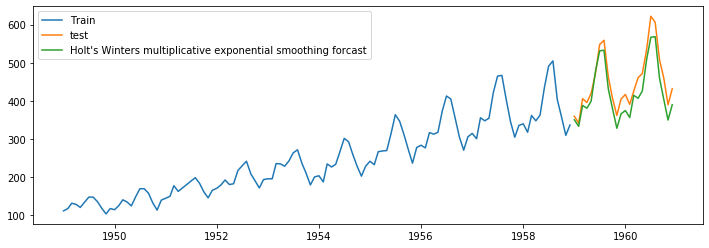

In [73]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_hwm['hwm_forecast'], label='Holt\'s Winters multiplicative exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [74]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hwm_forecast'])).round(2)
rmse

34.46

In [75]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_hwm['hwm_forecast'])/test['Passengers'])*100),2)
mape

6.82

In [76]:
results = results.append({'Method':'Holt\'s Winter multiplicative method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54
3,Simple expenential smoothing method,107.65,16.49
4,Holt's expenential smoothing method,71.94,11.11
5,Holt's Winter additive method,35.10,6.53
6,Holt's Winter multiplicative method,34.46,6.82


#### Analysis
1. We can see that both Additive and multiplicate performed more or less well for forecasting.

# Time Series Forecasting - II

# Auto Regressive Model (AR)

## Stationary vs Non-stationary Time Series

### 1. Visually checking the Stationarity 

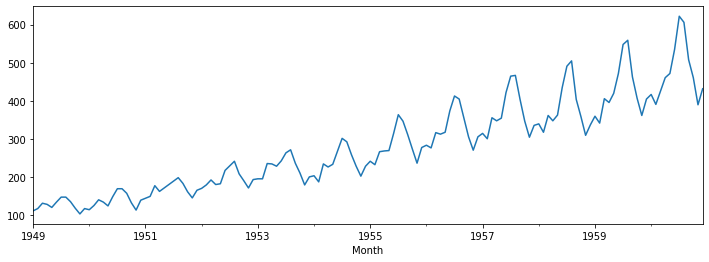

In [77]:
data['Passengers'].plot(figsize=(12,4))
plt.show()

#### Analysis
1. We can see that there is an increasing Trend. So, Trend is not constant.
2. Variance is also not constant.

Hence the time serise is not stationary. 

### 2. Augmented Dickey-Fuller (ADF) Test 

Null Hypothesis (H0): The series is not stationary

p-val > 0.05

Alternate Hypothesis (H1): The series is stationary

p-val <= 0.05

In [78]:
from statsmodels.tsa.stattools import adfuller

In [79]:
adf_test = adfuller(data['Passengers'])
adf_test

(0.8946087940823946,
 0.9930195647605925,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 993.7736365973918)

In [80]:
print('ADF stats: %f' % adf_test[0])
print('p-value: %f' %adf_test[1])
print('Critical value @ 0.05: %.2f' % adf_test[4]['5%'])

ADF stats: 0.894609
p-value: 0.993020
Critical value @ 0.05: -2.88


#### Analysis
p-value (0.99) > critical value(0.05) . 

Failed to reject null hypothesis (The series is not stationary)

Hence, the time series is Non-Stationary. 

### 3. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

Null Hypothesis (H0): The series is stationary

p-val>0.05

Alternate Hypothesis (H1): The series is not stationary

p-val <= 0.05

In [81]:
from statsmodels.tsa.stattools import kpss

In [82]:
kpss_test = kpss(data['Passengers'])
kpss_test

(1.0520501504573112,
 0.01,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [83]:
print('KPSS stats: %f' % kpss_test[0])
print('p-value: %f' %kpss_test[1])
print('Critical value @ 0.05: %.2f' % kpss_test[3]['5%'])

KPSS stats: 1.052050
p-value: 0.010000
Critical value @ 0.05: 0.46


#### Analysis
1. p-val(0.01) < Critical value(0.05) 

Reject the null hypothesis (The series is stationary)

Hence, as per alternate hypothesis the time series is ***non stationary***. 

## Converting Non-Stationary to Stationary Time Series

### Box Cox Transformation

Box-Cox transformation makes the variance constant in a series.

In [84]:
from scipy.stats import boxcox

In [85]:
# Creating a new dataset with the boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), data.index)
data_boxcox.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
dtype: float64

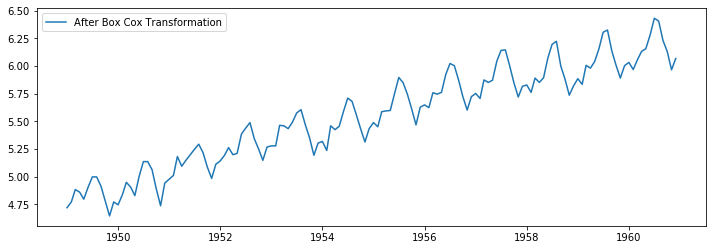

In [86]:
# Plotting the Time series after transformation
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox Transformation')
plt.legend(loc='best')
plt.show()

#### Analysis
1. We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance is almost similar.
2. But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do `Differencing` for making the mean constant. 

### Differencing

Differencing is performed by subtracting the previous observation from the current observation.

Differencing removes trend and seasonality in a Time series. When an entire cycle is used for differencing the other cycle, then the seasonality is removed.

In [87]:
# data_boxcox - data_boxcox.shift() :- Performs difference between the previous and current observations.
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index=data.index)

In [88]:
# As the first record becomes null. Hence removing the frist observation.
data_boxcox_diff.dropna(inplace=True)

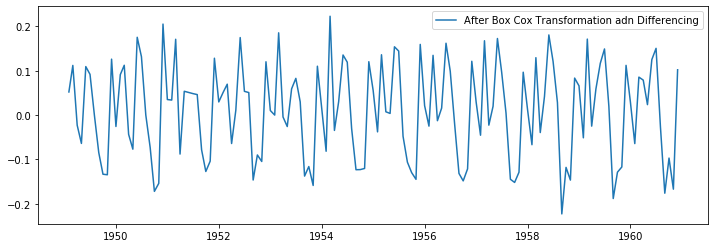

In [89]:
# Plotting the Time series after Box Cox transformation and Differencing
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation adn Differencing')
plt.legend(loc='best')
plt.show()

#### Analysis
1. We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation. 
2. It is a horizontal trend.
3. The mean became constant. The mean is zero.
4. Also, the variance is almost constant.

Lets test the Stationarity again.

#### ADF Test

In [90]:
adf_test = adfuller(data_boxcox_diff)
adf_test

(-3.290113818459414,
 0.015326212237944363,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -438.57103816956396)

In [91]:
print('ADF stats: %f' % adf_test[0])
print('p-value: %f' %adf_test[1])
print('Critical value @ 0.05: %.2f' % adf_test[4]['5%'])

ADF stats: -3.290114
p-value: 0.015326
Critical value @ 0.05: -2.88


p-value(0.01) < critical value(0.05)

ADF stats < Critical value . 

Hence, Reject the null hypothesis. 

The series is ***Stationary***.

## Autocorrelation

### Autocorrelation function (ACF)

Autocorrelation function captures both direct and indirect relationship with its lagged values. 

In [92]:
from statsmodels.graphics.tsaplots import plot_acf

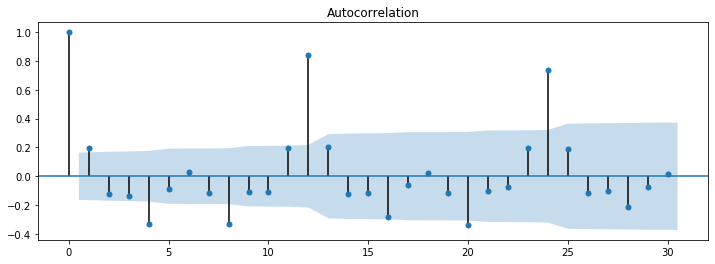

In [93]:
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

#### Analysis
1. The shaded portion is the less significant.
2. With lag 0, the series is just correlated with itself. Hence, correlation=1 at lag=0.
3. ACF captures both direct and indirect correlation with the lag time. 

E.g.:- At lag=5, y(t) is directly correlated with y(t-5).

Also, y(t) is indirectly correlated with y(t-5) through y(t-4), y(t-3), y(t-2) and y(t-1).

### Partial autocorrelation function (PACF)

Captures only direct correlation.

In [94]:
from statsmodels.graphics.tsaplots import plot_pacf

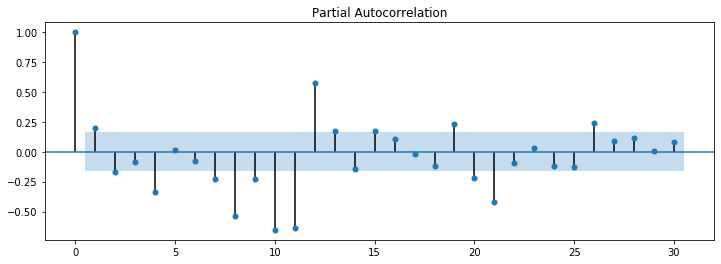

In [95]:
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

#### Analysis
1. Little change in the correlation plot. Because PACF only captures the direct correlation with the time lag. It bypasses the tile lags in between.

## Building the Regression Model

### Splitting Stationary dataset into train and test set 

In [96]:
# Splitting data_boxcox
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

In [97]:
# Splitting data_boxcox_diff

# Taking train_len-1 because we have deleted the forst observation
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

### Simple Auto Regressive Model (AR)

In [98]:
from statsmodels.tsa.arima_model import ARIMA

***order(p,d,q)***

p = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series.

d = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary.


q = This variable denotes the lag of the error component, where error component is a part of the time series not explained by trend or seasonality.

In [99]:
# p = 1 . We are calculating only one lag time period 
# q = 0 . We have already made the time series as Stationary
model = ARIMA(train_data_boxcox_diff, order=(1,0,0))

In [100]:
model_fit = model.fit()
model_fit.params

const      0.009477
ar.L1.y    0.183116
dtype: float64

constant = 0 . Because we saw in the Stationary time series that the mean was almost close to zero.

Coefficient = 0.183

The AR model has only one lag or p=1. Hence, we can represent the model as ***AR(1)***

#### Forecast

In [101]:
y_hat_ar = data_boxcox_diff.copy()

In [102]:
# We are predicting for all the observations train and test set both just to visualise the regression line
# The index column represents the timestamp. So, we are taking all the timestamps from first(index.min) to last(index.max)
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

#### Recover original time series forecast

As we have converted the original time series to Stationary series by consecutively applying BoxCox transformation and Differencing. We have to transform the series back to the original one (step by step).

In [103]:
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()

In [104]:
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])

In [105]:
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

#### Plot

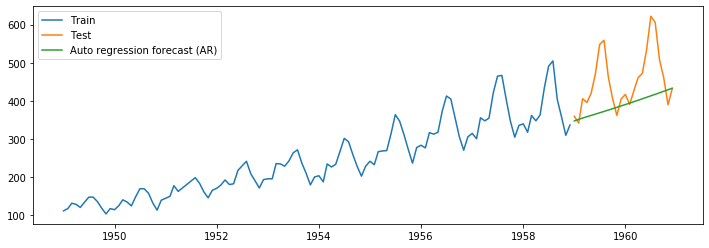

In [106]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

#### Analysis
1. We can see that we have done moderately well.
2. No Seasonality captured.

In [107]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
rmse

93.39

In [108]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_ar['ar_forecast'][test.index.min():])/test['Passengers'])*100),2)
mape

13.77

In [109]:
results = results.append({'Method':'Auto regressive (AR) method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54
3,Simple expenential smoothing method,107.65,16.49
4,Holt's expenential smoothing method,71.94,11.11
5,Holt's Winter additive method,35.10,6.53
6,Holt's Winter multiplicative method,34.46,6.82
7,Auto regressive (AR) method,93.39,13.77


#### Analysis
1. We can see that AR model has done reasonably good job but not better than Holt's method.

### Moving Average method (MA)

The Moving Average Model models the future forecasts using past forecast errors in a regression-like model. This model has a parameter ‘q’ called window size, over which linear combination of errors are calculated.

In [110]:
# q parameter = 1 MA(1) model
# If q = 3 , then it would be MA(3) model
# p = 0 and d = 0 As we are not considering these two parameters in this model.
model = ARIMA(train_data_boxcox_diff, order=(0,0,1))

In [111]:
model_fit = model.fit()
model_fit.params

const      0.009538
ma.L1.y    0.266103
dtype: float64

ma.L1.y = It is the coefficient, which is multiplied with the previous error term.

The model is ***MA(1) as q = 1.***

In [112]:
y_hat_ma = data_boxcox_diff.copy()

In [113]:
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

#### Recover original time series forecast

In [114]:
# Removing Differencing
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()

In [115]:
# Adding the first Ovservation
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])

In [116]:
# Removing the transformation
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

#### Plot

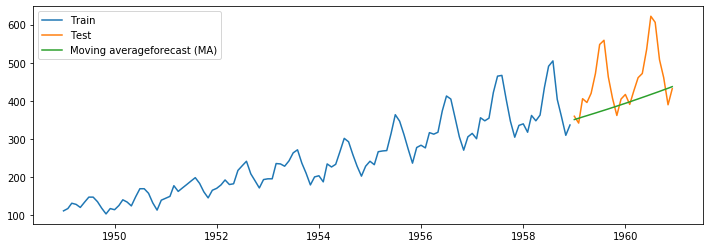

In [117]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving averageforecast (MA)')
plt.legend(loc='best')
plt.show()

Still there is no Seasonality captured.

In [118]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
rmse

91.21

In [119]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_ma['ma_forecast'][test.index.min():])/test['Passengers'])*100),2)
mape

13.39

In [120]:
results = results.append({'Method':'Moving average (MA) method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54
3,Simple expenential smoothing method,107.65,16.49
4,Holt's expenential smoothing method,71.94,11.11
5,Holt's Winter additive method,35.10,6.53
6,Holt's Winter multiplicative method,34.46,6.82
7,Auto regressive (AR) method,93.39,13.77
8,Moving average (MA) method,91.21,13.39


#### Analysis
1. The MA and AR method have almost same results.

### Auto Regressive Moving Average (ARMA)

A time series that exhibits the characteristics of an AR(p) and/or MA(q) process can be modelled using an ARMA(p,q) model.

In [121]:
# p=1 and q=1
model = ARIMA(train_data_boxcox_diff, order=(1,0,1))

In [122]:
model_fit = model.fit()
model_fit.params

const      0.009624
ar.L1.y   -0.527115
ma.L1.y    0.798281
dtype: float64

This is an ARMA(1,1) model, where AR coefficient = -0.527 and MA coefficient = 0.798

In [123]:
y_hat_arma = data_boxcox_diff.copy()

In [124]:
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

In [125]:
# Reverse the differencing
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()

In [126]:
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])

In [127]:
# Reverse the transformation
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

#### Plot

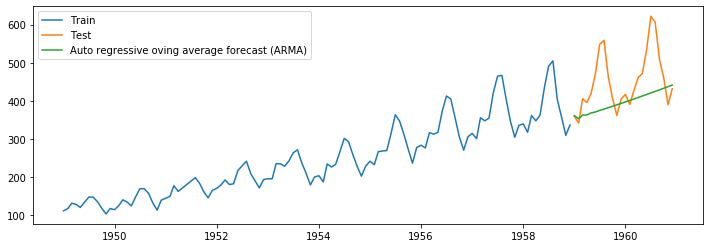

In [128]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='Auto regressive oving average forecast (ARMA)')
plt.legend(loc='best')
plt.show()

In [129]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arma['arma_forecast'][test.index.min():])).round(2)
rmse

88.88

In [130]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_arma['arma_forecast'][test.index.min():])/test['Passengers'])*100),2)
mape

12.89

In [131]:
results = results.append({'Method':'Auto regressive moving average (ARMA) method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54
3,Simple expenential smoothing method,107.65,16.49
4,Holt's expenential smoothing method,71.94,11.11
5,Holt's Winter additive method,35.10,6.53
6,Holt's Winter multiplicative method,34.46,6.82
7,Auto regressive (AR) method,93.39,13.77
8,Moving average (MA) method,91.21,13.39
9,Auto regressive moving average (ARMA) method,88.88,12.89


#### Analysis
1. Little better than AR and MA method.
2. Doesn't capture seasonality. Only captures level and trend.
3. Better than Simple Exponential Smoothing method. 

We souldn't compare it with Holt's method. Because Holt's method captures seasonality, but ARMA doesn't.

### Auto Regressive Integrated Moving Average (ARIMA)

Automatically performs the Differencing if the series has trend.

Hence, no need to manually perform the differencing.

In [179]:
# Passing only the transformed boxcox data. Because ARIMA automatically performing the differencing.
# p = 1
# q = 1
# d = 1   , We are doing only one order differencing.
model = ARIMA(train_data_boxcox, order=(1,1,1))

In [180]:
model_fit = model.fit()
model_fit.params

const        0.009624
ar.L1.D.y   -0.527115
ma.L1.D.y    0.798281
dtype: float64

We can notice that the coefficients of ARIMA model are same as ARMA model.

Because in ARMA modle :- We are manually doing the differencing. But in ARIMA model the differencing happening automatically. So, both the ARMA and ARIMA are doing the same thing.

In [134]:
y_hat_arima = data_boxcox_diff.copy()

In [135]:
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

In [136]:
# Reverse the differencing
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()

In [137]:
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])

In [138]:
# Reverse the transformation
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

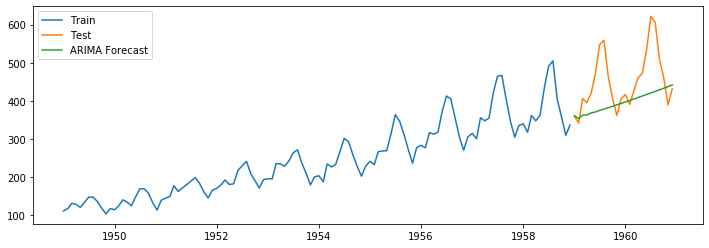

In [139]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA Forecast')
plt.legend(loc='best')
plt.show()

In [140]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
rmse

88.88

In [141]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_arima['arima_forecast'][test.index.min():])/test['Passengers'])*100),2)
mape

12.89

In [142]:
results = results.append({'Method':'ARIMA method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54
3,Simple expenential smoothing method,107.65,16.49
4,Holt's expenential smoothing method,71.94,11.11
5,Holt's Winter additive method,35.10,6.53
6,Holt's Winter multiplicative method,34.46,6.82
7,Auto regressive (AR) method,93.39,13.77
8,Moving average (MA) method,91.21,13.39
9,Auto regressive moving average (ARMA) method,88.88,12.89


As expected, we can see that there is no difference between ARIMA and ARMA methods. Because one is automatic differencing and another is manual.

### Seasonal Auto Regressive Integrated Moving Average (SARIMA)

ARIMA with Seasonal component added.

In [143]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [144]:
# We are only passing the Box Cox because the ARIMAX will perform the differencing internally
# seasonal_order P=1, Q=1, D=1 and m=12
# m=12 . Because the seasonality is monthly.
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))

In [145]:
model_fit = model.fit()
model_fit.params

ar.L1       0.394261
ma.L1      -0.685575
ar.S.L12   -0.040504
ma.S.L12   -0.518617
sigma2      0.001408
dtype: float64

ar.L1       0.394261 = Coefficients of AR for the trend (p) 

ma.L1      -0.685575 = Coeff of MA for the trend (q)

ar.S.L12   -0.040504 = Coeff for AR for the seasonality (P)

ma.S.L12   -0.518617 = Coeff of MA for the seasonality (Q)

sigma2      0.001408 = Intercept

In [146]:
# We are copying data_boxcox_diff because we have to compare the test data with the Stationary version of the series (Transformation + Differencing)
y_hat_sarima = data_boxcox_diff.copy()

In [147]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

##### Reverse original time series forecast
Note that ARIMAM automatically takes care of the reversing of `Differencing` (takes care the `Integration` part automatically). So, we don't need to perform the cumsum here. We only have to do the reverse of the log boc cox transformation.

In ARIMA, we had to perform the cumsum manually.

In [148]:
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

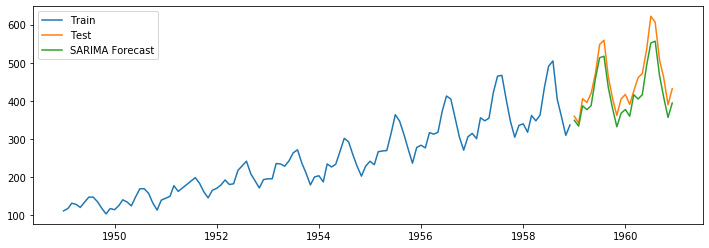

In [149]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

We can see that we are able to capture the trend and seasonality both.

In [150]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
rmse

37.32

In [151]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_sarima['sarima_forecast'][test.index.min():])/test['Passengers'])*100),2)
mape

7.32

In [152]:
results = results.append({'Method':'SARIMA method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54
3,Simple expenential smoothing method,107.65,16.49
4,Holt's expenential smoothing method,71.94,11.11
5,Holt's Winter additive method,35.10,6.53
6,Holt's Winter multiplicative method,34.46,6.82
7,Auto regressive (AR) method,93.39,13.77
8,Moving average (MA) method,91.21,13.39
9,Auto regressive moving average (ARMA) method,88.88,12.89


1. SARIMA method has done reasonably well as it captures seasonality.
2. Teh performance is comparable with the other method such as Holt's Winter additive/multiplicative, whcich also cpatures seasonality. 

### Seasonal Auto Regressive Integrated Moving Average with External Variables (SARIMAX)

In [157]:
# Promotional dataset
promo = pd.read_csv('promotion.csv', header=None)
promo.columns = ['Month', 'Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo.head()

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0


In [158]:
## Splitting promotional dataset into train and test set
promo_train = promo[:train_len]
promo_test = promo[train_len:]

In [160]:
# exog=promo_train :- Passing the external/exogenous variable
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12), exog=promo_train)

In [161]:
model_fit = model.fit()
model_fit.params

Event       0.034377
ar.L1       0.478218
ma.L1      -0.741620
ar.S.L12   -0.065750
ma.S.L12   -0.556732
sigma2      0.001334
dtype: float64

Event       0.034377 = Coefficient of the exogenous variable

In [162]:
y_hat_sarimax = data_boxcox_diff.copy()

In [163]:
# Predicting only for test data. Not the entire series.
# Passing the exogenous test data
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(test.index.min(), test.index.max(), exog=promo_test)

In [164]:
# Reversing the transformation
# Note:- Reversing the differencing is automatically taken care by SARIMAX
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

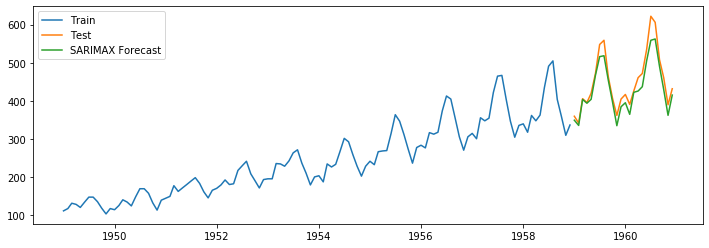

In [166]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'], label='SARIMAX Forecast')
plt.legend(loc='best')
plt.show()

We can see taht the forecast is almost hugging the actual plot. There may be only deviation on the peaks of the forecast.

In [167]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarimax['sarimax_forecast'][test.index.min():])).round(2)
rmse

26.63

In [168]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_sarimax['sarimax_forecast'][test.index.min():])/test['Passengers'])*100),2)
mape

4.65

In [169]:
results = results.append({'Method':'SARIMAX method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
1,Simple average method,219.69,44.28
2,Simple moving average method,103.33,15.54
3,Simple expenential smoothing method,107.65,16.49
4,Holt's expenential smoothing method,71.94,11.11
5,Holt's Winter additive method,35.10,6.53
6,Holt's Winter multiplicative method,34.46,6.82
7,Auto regressive (AR) method,93.39,13.77
8,Moving average (MA) method,91.21,13.39
9,Auto regressive moving average (ARMA) method,88.88,12.89


#### Analysis
1. The best model we have got so far with the lowest RMSE and lowest MAPE.